In [70]:
from ksql import KSQLAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
client = KSQLAPI('http://localhost:8088/')

In [7]:
client.ksql('show topics')

[{'@type': 'kafka_topics',
  'statementText': 'show topics;',
  'topics': [{'name': 'default_ksql_processing_log', 'replicaInfo': [1]},
   {'name': 'raw-phone-stream', 'replicaInfo': [1]}],
  'warnings': []}]

In [8]:
client.create_stream(table_name='device_stream',
                     columns_type=['name varchar',
                                   'time bigint',
                                   'values_x double',
                                   'values_y double',
                                   'values_z double',
                                   'messageId bigint',
                                   'sessionId varchar',
                                   'deviceId varchar'
                                   ],
                     topic='raw-phone-stream',
                     value_format='JSON')

True

In [9]:
client.ksql('show tables')

[{'@type': 'tables',
  'statementText': 'show tables;',
  'tables': [],
  'warnings': []}]

In [79]:
recent_stream = client.query('''
    select deviceId,
           time,
           values_x,
           values_y,
           values_z
    from device_stream
    where name = 'accelerometer'
    and time >= unix_timestamp() - 1000
    emit changes
''', use_http2=True)

In [80]:
data = []
for i,row in enumerate(recent_stream):

    try:
        if i > 0:
            data.append(json.loads(row.replace('\n','')))
            print(data[-1])
            print(i)
    except:
        print(row)
    

['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977347440000, 0.027028365244343874, 0.010519202057272196, 0.08835457527935504]
1
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977367494000, 0.27598062197603285, -0.07458426247164607, -0.1637935548841953]
2
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977387547100, 0.23696137468665837, 0.02054755185768008, -0.010217442631721496]
3
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977407601000, -0.042499563685804605, 0.04691416525766253, 0.19299334588348865]
4
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977427654100, -0.028200112437456844, -0.09886807824820279, 0.16013094072341919]
5
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977447708000, -0.0077354896228760475, -0.042743017052859066, -0.008873626807332039]
6
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977467761200, 0.12963855263032018, 0.11994812954738736, 0.05723638343811035]
7
['86a5b0e3-6e06-40e2-b226-5a72bd39b65b', 1680272977487814000, 0.05113514395356178, 0.050275458

KeyboardInterrupt: 

In [81]:
data = pd.DataFrame(np.array(data), columns=['id','time','x','y','z'])
data['time'] = data['time'].astype(int)
for axis in ['x','y','z']:

    data[axis] = data[axis].astype(float)

data['time'] = pd.to_datetime(data['time'].values)
data.sort_values('time', inplace=True)
data

,id,time,x,y,z
0,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:37.347440000,0.027028,0.010519,0.088355
1,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:37.367494000,0.275981,-0.074584,-0.163794
2,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:37.387547100,0.236961,0.020548,-0.010217
3,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:37.407601000,-0.042500,0.046914,0.192993
4,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:37.427654100,-0.028200,-0.098868,0.160131
...,...,...,...,...,...
290,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:43.162960400,0.356509,0.176554,-0.349396
291,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:43.183014400,0.135333,0.189713,-0.021068
292,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:43.203068200,0.019361,-0.001553,0.133312
293,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-03-31 14:29:43.223121400,-0.354338,-0.358067,0.450282


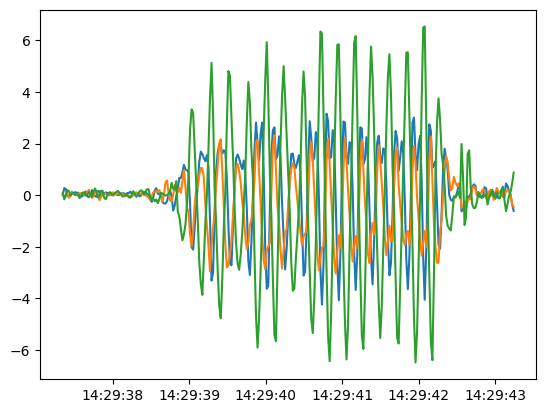

In [82]:
for axis in ['x','y','z']:
    plt.plot(data['time'], data[axis])